In [56]:
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch import nn
from torch.optim import Adam
from plot_keras_history import show_history, plot_history
from tqdm import tqdm

from functions.model_emotion_classifier import EmotionClassifier

In [57]:
# Version of the libraries used
print('\n'.join(f'{m.__name__} - {m.__version__}'
                for m in globals().values()
                if getattr(m, '__version__', None)))

torch - 2.3.0+cu118
numpy - 1.26.3


---

In [58]:
# Define transformations for images
transform = transforms.Compose([
    transforms.Grayscale(),  # Convert images to grayscale
    transforms.Resize((48, 48)),  # Resize images to 48x48 pixels
    transforms.ToTensor(),  # Convert images to tensors
])

# Create training and validation datasets
train_data = datasets.ImageFolder('../data/train', transform=transform)
validation_data = datasets.ImageFolder('../data/validation', transform=transform)

# Get the list of labels
labels = train_data.targets

# Count the number of samples per class
class_counts = np.bincount(labels)

# Calculate weights
weights = 1. / torch.tensor(class_counts, dtype=torch.float)

# Get sample weights
sample_weights = weights[labels]

# Create a weighted sampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Use the sampler in the DataLoader
train_loader = DataLoader(train_data, batch_size=64, sampler=sampler)

# Create a validation DataLoader
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=False)

# Create a dictionary of DataLoaders
dataloaders = {'train': train_loader, 'validation': validation_loader}

# Create a dictionary of data sizes
dataset_sizes = {'train': len(train_data), 'validation': len(validation_data)}

In [59]:
# Get the match between class indices and class names
class_to_idx = train_data.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

print(idx_to_class)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [60]:
# Create an instance of the model
model = EmotionClassifier()

# Define optimizer and loss function
optimizer = Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [61]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EmotionClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=512, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (dropout4): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (dropout5): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=128, out_features=7, bias=True)
)

In [62]:
# Train the model
epochs = 150

# Initialize history
history = {'train_loss': [], 'validation_loss': [], 'train_acc': [], 'validation_acc': []}

# Copy model weights
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

start_time = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        # Add epoch to tqdm description
        for inputs, labels in tqdm(dataloaders[phase], desc=f"Epoch {epoch+1}"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero parameter gradients
            optimizer.zero_grad()

            # forward
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # Add statistics to history
        history[phase+'_loss'].append(epoch_loss)
        history[phase+'_acc'].append(epoch_acc)

        # copy the model if it is the best
        if phase == 'validation' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, '../weights/best_emotion_classifier.pth')

    print()

end_time = time.time()
print('Best val Acc: {:4f}'.format(best_acc))

Epoch 1/150


Epoch 1: 100%|██████████| 451/451 [00:14<00:00, 31.00it/s]


train Loss: 1.9230 Acc: 0.1883


Epoch 1: 100%|██████████| 111/111 [00:02<00:00, 41.08it/s]


validation Loss: 1.8307 Acc: 0.3002

Epoch 2/150


Epoch 2: 100%|██████████| 451/451 [00:14<00:00, 30.54it/s]


train Loss: 1.8317 Acc: 0.2519


Epoch 2: 100%|██████████| 111/111 [00:02<00:00, 41.49it/s]


validation Loss: 1.7672 Acc: 0.2935

Epoch 3/150


Epoch 3: 100%|██████████| 451/451 [00:16<00:00, 26.71it/s]


train Loss: 1.7824 Acc: 0.2963


Epoch 3: 100%|██████████| 111/111 [00:03<00:00, 35.01it/s]


validation Loss: 1.7779 Acc: 0.3204

Epoch 4/150


Epoch 4: 100%|██████████| 451/451 [00:17<00:00, 25.81it/s]


train Loss: 1.7514 Acc: 0.3126


Epoch 4: 100%|██████████| 111/111 [00:03<00:00, 35.66it/s]


validation Loss: 1.7613 Acc: 0.2956

Epoch 5/150


Epoch 5: 100%|██████████| 451/451 [00:14<00:00, 31.90it/s]


train Loss: 1.7271 Acc: 0.3218


Epoch 5: 100%|██████████| 111/111 [00:02<00:00, 42.18it/s]


validation Loss: 1.6812 Acc: 0.3394

Epoch 6/150


Epoch 6: 100%|██████████| 451/451 [00:14<00:00, 31.78it/s]


train Loss: 1.7142 Acc: 0.3287


Epoch 6: 100%|██████████| 111/111 [00:03<00:00, 36.54it/s]


validation Loss: 1.7498 Acc: 0.2928

Epoch 7/150


Epoch 7: 100%|██████████| 451/451 [00:14<00:00, 32.08it/s]


train Loss: 1.6946 Acc: 0.3375


Epoch 7: 100%|██████████| 111/111 [00:02<00:00, 42.36it/s]


validation Loss: 1.7768 Acc: 0.2760

Epoch 8/150


Epoch 8: 100%|██████████| 451/451 [00:16<00:00, 26.66it/s]


train Loss: 1.6792 Acc: 0.3464


Epoch 8: 100%|██████████| 111/111 [00:03<00:00, 30.98it/s]


validation Loss: 1.7409 Acc: 0.3221

Epoch 9/150


Epoch 9: 100%|██████████| 451/451 [00:19<00:00, 22.76it/s]


train Loss: 1.6574 Acc: 0.3583


Epoch 9: 100%|██████████| 111/111 [00:03<00:00, 33.28it/s]


validation Loss: 1.6318 Acc: 0.3736

Epoch 10/150


Epoch 10: 100%|██████████| 451/451 [00:18<00:00, 23.75it/s]


train Loss: 1.6419 Acc: 0.3647


Epoch 10: 100%|██████████| 111/111 [00:03<00:00, 31.25it/s]


validation Loss: 1.6691 Acc: 0.3613

Epoch 11/150


Epoch 11: 100%|██████████| 451/451 [00:19<00:00, 23.17it/s]


train Loss: 1.6244 Acc: 0.3761


Epoch 11: 100%|██████████| 111/111 [00:03<00:00, 30.36it/s]


validation Loss: 1.6767 Acc: 0.3695

Epoch 12/150


Epoch 12: 100%|██████████| 451/451 [00:19<00:00, 22.95it/s]


train Loss: 1.6029 Acc: 0.3809


Epoch 12: 100%|██████████| 111/111 [00:03<00:00, 28.93it/s]


validation Loss: 1.7080 Acc: 0.3358

Epoch 13/150


Epoch 13: 100%|██████████| 451/451 [00:18<00:00, 24.11it/s]


train Loss: 1.5981 Acc: 0.3804


Epoch 13: 100%|██████████| 111/111 [00:02<00:00, 40.92it/s]


validation Loss: 1.7556 Acc: 0.3105

Epoch 14/150


Epoch 14: 100%|██████████| 451/451 [00:14<00:00, 31.96it/s]


train Loss: 1.5843 Acc: 0.3884


Epoch 14: 100%|██████████| 111/111 [00:02<00:00, 41.60it/s]


validation Loss: 1.6460 Acc: 0.3742

Epoch 15/150


Epoch 15: 100%|██████████| 451/451 [00:13<00:00, 32.35it/s]


train Loss: 1.5621 Acc: 0.3969


Epoch 15: 100%|██████████| 111/111 [00:02<00:00, 38.94it/s]


validation Loss: 1.7288 Acc: 0.3404

Epoch 16/150


Epoch 16: 100%|██████████| 451/451 [00:14<00:00, 32.12it/s]


train Loss: 1.5598 Acc: 0.3963


Epoch 16: 100%|██████████| 111/111 [00:02<00:00, 41.75it/s]


validation Loss: 1.6783 Acc: 0.3605

Epoch 17/150


Epoch 17: 100%|██████████| 451/451 [00:13<00:00, 32.61it/s]


train Loss: 1.5519 Acc: 0.3985


Epoch 17: 100%|██████████| 111/111 [00:02<00:00, 43.67it/s]


validation Loss: 1.6483 Acc: 0.3793

Epoch 18/150


Epoch 18: 100%|██████████| 451/451 [00:14<00:00, 31.94it/s]


train Loss: 1.5384 Acc: 0.4040


Epoch 18: 100%|██████████| 111/111 [00:02<00:00, 44.70it/s]


validation Loss: 1.6545 Acc: 0.3726

Epoch 19/150


Epoch 19: 100%|██████████| 451/451 [00:13<00:00, 32.52it/s]


train Loss: 1.5387 Acc: 0.4035


Epoch 19: 100%|██████████| 111/111 [00:02<00:00, 42.60it/s]


validation Loss: 1.6412 Acc: 0.3789

Epoch 20/150


Epoch 20: 100%|██████████| 451/451 [00:14<00:00, 30.78it/s]


train Loss: 1.5230 Acc: 0.4094


Epoch 20: 100%|██████████| 111/111 [00:02<00:00, 40.33it/s]


validation Loss: 1.6901 Acc: 0.3457

Epoch 21/150


Epoch 21: 100%|██████████| 451/451 [00:14<00:00, 31.42it/s]


train Loss: 1.5102 Acc: 0.4128


Epoch 21: 100%|██████████| 111/111 [00:02<00:00, 42.46it/s]


validation Loss: 1.6285 Acc: 0.3818

Epoch 22/150


Epoch 22: 100%|██████████| 451/451 [00:13<00:00, 33.45it/s]


train Loss: 1.5060 Acc: 0.4154


Epoch 22: 100%|██████████| 111/111 [00:02<00:00, 43.08it/s]


validation Loss: 1.6483 Acc: 0.3746

Epoch 23/150


Epoch 23: 100%|██████████| 451/451 [00:13<00:00, 32.43it/s]


train Loss: 1.4964 Acc: 0.4171


Epoch 23: 100%|██████████| 111/111 [00:02<00:00, 41.97it/s]


validation Loss: 1.6338 Acc: 0.3818

Epoch 24/150


Epoch 24: 100%|██████████| 451/451 [00:13<00:00, 32.60it/s]


train Loss: 1.4910 Acc: 0.4229


Epoch 24: 100%|██████████| 111/111 [00:03<00:00, 34.62it/s]


validation Loss: 1.6580 Acc: 0.3711

Epoch 25/150


Epoch 25: 100%|██████████| 451/451 [00:14<00:00, 30.79it/s]


train Loss: 1.4798 Acc: 0.4249


Epoch 25: 100%|██████████| 111/111 [00:02<00:00, 43.94it/s]


validation Loss: 1.5941 Acc: 0.4029

Epoch 26/150


Epoch 26: 100%|██████████| 451/451 [00:14<00:00, 31.35it/s]


train Loss: 1.4750 Acc: 0.4282


Epoch 26: 100%|██████████| 111/111 [00:02<00:00, 42.42it/s]


validation Loss: 1.6354 Acc: 0.3777

Epoch 27/150


Epoch 27: 100%|██████████| 451/451 [00:13<00:00, 32.91it/s]


train Loss: 1.4667 Acc: 0.4295


Epoch 27: 100%|██████████| 111/111 [00:02<00:00, 43.44it/s]


validation Loss: 1.6592 Acc: 0.3688

Epoch 28/150


Epoch 28: 100%|██████████| 451/451 [00:13<00:00, 32.95it/s]


train Loss: 1.4653 Acc: 0.4324


Epoch 28: 100%|██████████| 111/111 [00:02<00:00, 44.19it/s]


validation Loss: 1.6160 Acc: 0.3868

Epoch 29/150


Epoch 29: 100%|██████████| 451/451 [00:13<00:00, 32.86it/s]


train Loss: 1.4517 Acc: 0.4341


Epoch 29: 100%|██████████| 111/111 [00:02<00:00, 43.51it/s]


validation Loss: 1.6122 Acc: 0.3797

Epoch 30/150


Epoch 30: 100%|██████████| 451/451 [00:13<00:00, 32.91it/s]


train Loss: 1.4496 Acc: 0.4396


Epoch 30: 100%|██████████| 111/111 [00:02<00:00, 44.31it/s]


validation Loss: 1.5820 Acc: 0.4114

Epoch 31/150


Epoch 31: 100%|██████████| 451/451 [00:13<00:00, 33.05it/s]


train Loss: 1.4337 Acc: 0.4404


Epoch 31: 100%|██████████| 111/111 [00:02<00:00, 43.63it/s]


validation Loss: 1.5670 Acc: 0.4212

Epoch 32/150


Epoch 32: 100%|██████████| 451/451 [00:13<00:00, 33.03it/s]


train Loss: 1.4337 Acc: 0.4437


Epoch 32: 100%|██████████| 111/111 [00:02<00:00, 43.40it/s]


validation Loss: 1.5768 Acc: 0.4288

Epoch 33/150


Epoch 33: 100%|██████████| 451/451 [00:13<00:00, 33.09it/s]


train Loss: 1.4219 Acc: 0.4432


Epoch 33: 100%|██████████| 111/111 [00:02<00:00, 43.40it/s]


validation Loss: 1.5370 Acc: 0.4335

Epoch 34/150


Epoch 34: 100%|██████████| 451/451 [00:13<00:00, 33.10it/s]


train Loss: 1.4095 Acc: 0.4492


Epoch 34: 100%|██████████| 111/111 [00:02<00:00, 43.89it/s]


validation Loss: 1.5619 Acc: 0.4237

Epoch 35/150


Epoch 35: 100%|██████████| 451/451 [00:13<00:00, 32.98it/s]


train Loss: 1.4119 Acc: 0.4476


Epoch 35: 100%|██████████| 111/111 [00:02<00:00, 40.78it/s]


validation Loss: 1.5419 Acc: 0.4309

Epoch 36/150


Epoch 36: 100%|██████████| 451/451 [00:13<00:00, 32.31it/s]


train Loss: 1.3949 Acc: 0.4621


Epoch 36: 100%|██████████| 111/111 [00:02<00:00, 43.80it/s]


validation Loss: 1.5513 Acc: 0.4165

Epoch 37/150


Epoch 37: 100%|██████████| 451/451 [00:14<00:00, 32.19it/s]


train Loss: 1.3969 Acc: 0.4562


Epoch 37: 100%|██████████| 111/111 [00:02<00:00, 43.27it/s]


validation Loss: 1.5213 Acc: 0.4445

Epoch 38/150


Epoch 38: 100%|██████████| 451/451 [00:13<00:00, 32.86it/s]


train Loss: 1.3819 Acc: 0.4650


Epoch 38: 100%|██████████| 111/111 [00:02<00:00, 42.46it/s]


validation Loss: 1.6052 Acc: 0.3803

Epoch 39/150


Epoch 39: 100%|██████████| 451/451 [00:13<00:00, 33.04it/s]


train Loss: 1.3862 Acc: 0.4570


Epoch 39: 100%|██████████| 111/111 [00:02<00:00, 43.46it/s]


validation Loss: 1.5719 Acc: 0.4090

Epoch 40/150


Epoch 40: 100%|██████████| 451/451 [00:13<00:00, 32.92it/s]


train Loss: 1.3767 Acc: 0.4639


Epoch 40: 100%|██████████| 111/111 [00:02<00:00, 43.61it/s]


validation Loss: 1.5222 Acc: 0.4370

Epoch 41/150


Epoch 41: 100%|██████████| 451/451 [00:13<00:00, 32.70it/s]


train Loss: 1.3586 Acc: 0.4702


Epoch 41: 100%|██████████| 111/111 [00:02<00:00, 44.54it/s]


validation Loss: 1.4866 Acc: 0.4556

Epoch 42/150


Epoch 42: 100%|██████████| 451/451 [00:13<00:00, 32.78it/s]


train Loss: 1.3503 Acc: 0.4710


Epoch 42: 100%|██████████| 111/111 [00:02<00:00, 43.59it/s]


validation Loss: 1.5419 Acc: 0.4098

Epoch 43/150


Epoch 43: 100%|██████████| 451/451 [00:13<00:00, 32.90it/s]


train Loss: 1.3459 Acc: 0.4763


Epoch 43: 100%|██████████| 111/111 [00:02<00:00, 42.31it/s]


validation Loss: 1.5311 Acc: 0.4299

Epoch 44/150


Epoch 44: 100%|██████████| 451/451 [00:13<00:00, 32.96it/s]


train Loss: 1.3457 Acc: 0.4777


Epoch 44: 100%|██████████| 111/111 [00:02<00:00, 43.57it/s]


validation Loss: 1.5305 Acc: 0.4232

Epoch 45/150


Epoch 45: 100%|██████████| 451/451 [00:13<00:00, 32.90it/s]


train Loss: 1.3364 Acc: 0.4803


Epoch 45: 100%|██████████| 111/111 [00:02<00:00, 43.50it/s]


validation Loss: 1.5104 Acc: 0.4423

Epoch 46/150


Epoch 46: 100%|██████████| 451/451 [00:14<00:00, 31.77it/s]


train Loss: 1.3379 Acc: 0.4773


Epoch 46: 100%|██████████| 111/111 [00:02<00:00, 43.94it/s]


validation Loss: 1.4605 Acc: 0.4662

Epoch 47/150


Epoch 47: 100%|██████████| 451/451 [00:14<00:00, 31.98it/s]


train Loss: 1.3199 Acc: 0.4911


Epoch 47: 100%|██████████| 111/111 [00:02<00:00, 42.10it/s]


validation Loss: 1.5001 Acc: 0.4280

Epoch 48/150


Epoch 48: 100%|██████████| 451/451 [00:14<00:00, 32.04it/s]


train Loss: 1.3126 Acc: 0.4903


Epoch 48: 100%|██████████| 111/111 [00:02<00:00, 42.92it/s]


validation Loss: 1.4659 Acc: 0.4489

Epoch 49/150


Epoch 49: 100%|██████████| 451/451 [00:14<00:00, 31.88it/s]


train Loss: 1.3102 Acc: 0.4875


Epoch 49: 100%|██████████| 111/111 [00:02<00:00, 43.13it/s]


validation Loss: 1.4819 Acc: 0.4568

Epoch 50/150


Epoch 50: 100%|██████████| 451/451 [00:13<00:00, 33.13it/s]


train Loss: 1.3182 Acc: 0.4850


Epoch 50: 100%|██████████| 111/111 [00:02<00:00, 42.25it/s]


validation Loss: 1.4608 Acc: 0.4731

Epoch 51/150


Epoch 51: 100%|██████████| 451/451 [00:13<00:00, 32.68it/s]


train Loss: 1.2908 Acc: 0.4969


Epoch 51: 100%|██████████| 111/111 [00:02<00:00, 41.47it/s]


validation Loss: 1.4841 Acc: 0.4469

Epoch 52/150


Epoch 52: 100%|██████████| 451/451 [00:13<00:00, 32.23it/s]


train Loss: 1.2956 Acc: 0.4952


Epoch 52: 100%|██████████| 111/111 [00:02<00:00, 44.05it/s]


validation Loss: 1.5019 Acc: 0.4530

Epoch 53/150


Epoch 53: 100%|██████████| 451/451 [00:13<00:00, 32.99it/s]


train Loss: 1.2906 Acc: 0.5000


Epoch 53: 100%|██████████| 111/111 [00:02<00:00, 44.01it/s]


validation Loss: 1.4237 Acc: 0.4901

Epoch 54/150


Epoch 54: 100%|██████████| 451/451 [00:13<00:00, 32.58it/s]


train Loss: 1.2762 Acc: 0.5063


Epoch 54: 100%|██████████| 111/111 [00:02<00:00, 41.16it/s]


validation Loss: 1.4355 Acc: 0.4755

Epoch 55/150


Epoch 55: 100%|██████████| 451/451 [00:13<00:00, 32.55it/s]


train Loss: 1.2728 Acc: 0.5033


Epoch 55: 100%|██████████| 111/111 [00:02<00:00, 42.17it/s]


validation Loss: 1.4471 Acc: 0.4638

Epoch 56/150


Epoch 56: 100%|██████████| 451/451 [00:14<00:00, 30.11it/s]


train Loss: 1.2806 Acc: 0.5027


Epoch 56: 100%|██████████| 111/111 [00:02<00:00, 40.42it/s]


validation Loss: 1.4662 Acc: 0.4631

Epoch 57/150


Epoch 57: 100%|██████████| 451/451 [00:14<00:00, 31.39it/s]


train Loss: 1.2750 Acc: 0.5037


Epoch 57: 100%|██████████| 111/111 [00:02<00:00, 41.31it/s]


validation Loss: 1.4569 Acc: 0.4745

Epoch 58/150


Epoch 58: 100%|██████████| 451/451 [00:13<00:00, 32.52it/s]


train Loss: 1.2608 Acc: 0.5153


Epoch 58: 100%|██████████| 111/111 [00:02<00:00, 42.58it/s]


validation Loss: 1.4598 Acc: 0.4718

Epoch 59/150


Epoch 59: 100%|██████████| 451/451 [00:13<00:00, 32.79it/s]


train Loss: 1.2701 Acc: 0.5074


Epoch 59: 100%|██████████| 111/111 [00:02<00:00, 42.48it/s]


validation Loss: 1.4414 Acc: 0.4785

Epoch 60/150


Epoch 60: 100%|██████████| 451/451 [00:14<00:00, 31.96it/s]


train Loss: 1.2592 Acc: 0.5107


Epoch 60: 100%|██████████| 111/111 [00:02<00:00, 38.99it/s]


validation Loss: 1.4553 Acc: 0.4686

Epoch 61/150


Epoch 61: 100%|██████████| 451/451 [00:14<00:00, 30.95it/s]


train Loss: 1.2483 Acc: 0.5126


Epoch 61: 100%|██████████| 111/111 [00:02<00:00, 39.71it/s]


validation Loss: 1.4096 Acc: 0.4837

Epoch 62/150


Epoch 62: 100%|██████████| 451/451 [00:14<00:00, 30.79it/s]


train Loss: 1.2445 Acc: 0.5165


Epoch 62: 100%|██████████| 111/111 [00:02<00:00, 43.47it/s]


validation Loss: 1.3894 Acc: 0.4960

Epoch 63/150


Epoch 63: 100%|██████████| 451/451 [00:13<00:00, 32.67it/s]


train Loss: 1.2402 Acc: 0.5118


Epoch 63: 100%|██████████| 111/111 [00:02<00:00, 43.34it/s]


validation Loss: 1.4546 Acc: 0.4612

Epoch 64/150


Epoch 64: 100%|██████████| 451/451 [00:14<00:00, 31.66it/s]


train Loss: 1.2386 Acc: 0.5224


Epoch 64: 100%|██████████| 111/111 [00:02<00:00, 40.24it/s]


validation Loss: 1.4707 Acc: 0.4682

Epoch 65/150


Epoch 65: 100%|██████████| 451/451 [00:13<00:00, 32.27it/s]


train Loss: 1.2331 Acc: 0.5211


Epoch 65: 100%|██████████| 111/111 [00:02<00:00, 42.76it/s]


validation Loss: 1.3820 Acc: 0.4945

Epoch 66/150


Epoch 66: 100%|██████████| 451/451 [00:13<00:00, 33.19it/s]


train Loss: 1.2214 Acc: 0.5262


Epoch 66: 100%|██████████| 111/111 [00:02<00:00, 42.91it/s]


validation Loss: 1.4318 Acc: 0.4693

Epoch 67/150


Epoch 67: 100%|██████████| 451/451 [00:13<00:00, 33.03it/s]


train Loss: 1.2252 Acc: 0.5257


Epoch 67: 100%|██████████| 111/111 [00:02<00:00, 42.65it/s]


validation Loss: 1.3574 Acc: 0.5058

Epoch 68/150


Epoch 68: 100%|██████████| 451/451 [00:13<00:00, 33.08it/s]


train Loss: 1.2056 Acc: 0.5314


Epoch 68: 100%|██████████| 111/111 [00:02<00:00, 43.93it/s]


validation Loss: 1.3655 Acc: 0.4992

Epoch 69/150


Epoch 69: 100%|██████████| 451/451 [00:13<00:00, 32.96it/s]


train Loss: 1.2175 Acc: 0.5286


Epoch 69: 100%|██████████| 111/111 [00:02<00:00, 44.27it/s]


validation Loss: 1.3758 Acc: 0.4990

Epoch 70/150


Epoch 70: 100%|██████████| 451/451 [00:13<00:00, 33.10it/s]


train Loss: 1.2113 Acc: 0.5319


Epoch 70: 100%|██████████| 111/111 [00:02<00:00, 44.31it/s]


validation Loss: 1.4034 Acc: 0.4885

Epoch 71/150


Epoch 71: 100%|██████████| 451/451 [00:13<00:00, 33.03it/s]


train Loss: 1.2008 Acc: 0.5351


Epoch 71: 100%|██████████| 111/111 [00:02<00:00, 41.62it/s]


validation Loss: 1.4001 Acc: 0.4873

Epoch 72/150


Epoch 72: 100%|██████████| 451/451 [00:14<00:00, 31.28it/s]


train Loss: 1.2005 Acc: 0.5375


Epoch 72: 100%|██████████| 111/111 [00:02<00:00, 41.30it/s]


validation Loss: 1.4157 Acc: 0.4758

Epoch 73/150


Epoch 73: 100%|██████████| 451/451 [00:13<00:00, 33.71it/s]


train Loss: 1.2107 Acc: 0.5306


Epoch 73: 100%|██████████| 111/111 [00:03<00:00, 29.87it/s]


validation Loss: 1.4042 Acc: 0.4878

Epoch 74/150


Epoch 74: 100%|██████████| 451/451 [00:14<00:00, 31.75it/s]


train Loss: 1.1997 Acc: 0.5421


Epoch 74: 100%|██████████| 111/111 [00:02<00:00, 44.47it/s]


validation Loss: 1.3574 Acc: 0.5074

Epoch 75/150


Epoch 75: 100%|██████████| 451/451 [00:14<00:00, 30.27it/s]


train Loss: 1.1801 Acc: 0.5441


Epoch 75: 100%|██████████| 111/111 [00:03<00:00, 33.37it/s]


validation Loss: 1.3946 Acc: 0.4969

Epoch 76/150


Epoch 76: 100%|██████████| 451/451 [00:14<00:00, 30.61it/s]


train Loss: 1.1846 Acc: 0.5448


Epoch 76: 100%|██████████| 111/111 [00:02<00:00, 40.36it/s]


validation Loss: 1.3810 Acc: 0.5037

Epoch 77/150


Epoch 77: 100%|██████████| 451/451 [00:13<00:00, 33.61it/s]


train Loss: 1.1870 Acc: 0.5431


Epoch 77: 100%|██████████| 111/111 [00:02<00:00, 45.36it/s]


validation Loss: 1.3766 Acc: 0.5017

Epoch 78/150


Epoch 78: 100%|██████████| 451/451 [00:12<00:00, 35.57it/s]


train Loss: 1.1807 Acc: 0.5489


Epoch 78: 100%|██████████| 111/111 [00:02<00:00, 44.80it/s]


validation Loss: 1.3926 Acc: 0.4880

Epoch 79/150


Epoch 79: 100%|██████████| 451/451 [00:13<00:00, 34.08it/s]


train Loss: 1.1809 Acc: 0.5491


Epoch 79: 100%|██████████| 111/111 [00:02<00:00, 47.41it/s]


validation Loss: 1.3699 Acc: 0.4966

Epoch 80/150


Epoch 80: 100%|██████████| 451/451 [00:12<00:00, 36.62it/s]


train Loss: 1.1806 Acc: 0.5481


Epoch 80: 100%|██████████| 111/111 [00:02<00:00, 47.54it/s]


validation Loss: 1.3403 Acc: 0.5020

Epoch 81/150


Epoch 81: 100%|██████████| 451/451 [00:12<00:00, 34.95it/s]


train Loss: 1.1698 Acc: 0.5533


Epoch 81: 100%|██████████| 111/111 [00:02<00:00, 45.80it/s]


validation Loss: 1.3319 Acc: 0.5139

Epoch 82/150


Epoch 82: 100%|██████████| 451/451 [00:12<00:00, 36.93it/s]


train Loss: 1.1745 Acc: 0.5528


Epoch 82: 100%|██████████| 111/111 [00:02<00:00, 46.88it/s]


validation Loss: 1.3649 Acc: 0.5058

Epoch 83/150


Epoch 83: 100%|██████████| 451/451 [00:12<00:00, 34.94it/s]


train Loss: 1.1619 Acc: 0.5560


Epoch 83: 100%|██████████| 111/111 [00:02<00:00, 45.49it/s]


validation Loss: 1.3865 Acc: 0.5003

Epoch 84/150


Epoch 84: 100%|██████████| 451/451 [00:13<00:00, 33.25it/s]


train Loss: 1.1497 Acc: 0.5607


Epoch 84: 100%|██████████| 111/111 [00:02<00:00, 37.66it/s]


validation Loss: 1.3258 Acc: 0.5130

Epoch 85/150


Epoch 85: 100%|██████████| 451/451 [00:13<00:00, 33.17it/s]


train Loss: 1.1633 Acc: 0.5556


Epoch 85: 100%|██████████| 111/111 [00:02<00:00, 43.66it/s]


validation Loss: 1.3413 Acc: 0.5250

Epoch 86/150


Epoch 86: 100%|██████████| 451/451 [00:13<00:00, 33.33it/s]


train Loss: 1.1552 Acc: 0.5585


Epoch 86: 100%|██████████| 111/111 [00:02<00:00, 41.70it/s]


validation Loss: 1.3612 Acc: 0.5093

Epoch 87/150


Epoch 87: 100%|██████████| 451/451 [00:13<00:00, 32.39it/s]


train Loss: 1.1447 Acc: 0.5640


Epoch 87: 100%|██████████| 111/111 [00:02<00:00, 43.82it/s]


validation Loss: 1.3408 Acc: 0.5183

Epoch 88/150


Epoch 88: 100%|██████████| 451/451 [00:13<00:00, 32.66it/s]


train Loss: 1.1473 Acc: 0.5611


Epoch 88: 100%|██████████| 111/111 [00:02<00:00, 43.15it/s]


validation Loss: 1.3163 Acc: 0.5286

Epoch 89/150


Epoch 89: 100%|██████████| 451/451 [00:13<00:00, 32.69it/s]


train Loss: 1.1543 Acc: 0.5646


Epoch 89: 100%|██████████| 111/111 [00:02<00:00, 43.83it/s]


validation Loss: 1.3276 Acc: 0.5255

Epoch 90/150


Epoch 90: 100%|██████████| 451/451 [00:13<00:00, 32.88it/s]


train Loss: 1.1420 Acc: 0.5668


Epoch 90: 100%|██████████| 111/111 [00:02<00:00, 43.70it/s]


validation Loss: 1.2905 Acc: 0.5398

Epoch 91/150


Epoch 91: 100%|██████████| 451/451 [00:13<00:00, 32.73it/s]


train Loss: 1.1405 Acc: 0.5669


Epoch 91: 100%|██████████| 111/111 [00:02<00:00, 43.86it/s]


validation Loss: 1.3470 Acc: 0.5085

Epoch 92/150


Epoch 92: 100%|██████████| 451/451 [00:13<00:00, 32.85it/s]


train Loss: 1.1333 Acc: 0.5693


Epoch 92: 100%|██████████| 111/111 [00:02<00:00, 44.11it/s]


validation Loss: 1.3092 Acc: 0.5267

Epoch 93/150


Epoch 93: 100%|██████████| 451/451 [00:13<00:00, 32.23it/s]


train Loss: 1.1395 Acc: 0.5636


Epoch 93: 100%|██████████| 111/111 [00:02<00:00, 42.97it/s]


validation Loss: 1.3079 Acc: 0.5276

Epoch 94/150


Epoch 94: 100%|██████████| 451/451 [00:13<00:00, 32.79it/s]


train Loss: 1.1336 Acc: 0.5712


Epoch 94: 100%|██████████| 111/111 [00:02<00:00, 43.91it/s]


validation Loss: 1.3787 Acc: 0.4915

Epoch 95/150


Epoch 95: 100%|██████████| 451/451 [00:13<00:00, 32.89it/s]


train Loss: 1.1289 Acc: 0.5722


Epoch 95: 100%|██████████| 111/111 [00:02<00:00, 44.13it/s]


validation Loss: 1.3188 Acc: 0.5318

Epoch 96/150


Epoch 96: 100%|██████████| 451/451 [00:13<00:00, 32.76it/s]


train Loss: 1.1307 Acc: 0.5752


Epoch 96: 100%|██████████| 111/111 [00:02<00:00, 43.43it/s]


validation Loss: 1.3610 Acc: 0.5192

Epoch 97/150


Epoch 97: 100%|██████████| 451/451 [00:13<00:00, 32.91it/s]


train Loss: 1.1163 Acc: 0.5766


Epoch 97: 100%|██████████| 111/111 [00:02<00:00, 42.64it/s]


validation Loss: 1.2913 Acc: 0.5396

Epoch 98/150


Epoch 98: 100%|██████████| 451/451 [00:13<00:00, 32.79it/s]


train Loss: 1.1218 Acc: 0.5758


Epoch 98: 100%|██████████| 111/111 [00:02<00:00, 42.62it/s]


validation Loss: 1.3318 Acc: 0.5290

Epoch 99/150


Epoch 99: 100%|██████████| 451/451 [00:13<00:00, 32.23it/s]


train Loss: 1.1052 Acc: 0.5837


Epoch 99: 100%|██████████| 111/111 [00:02<00:00, 42.93it/s]


validation Loss: 1.2782 Acc: 0.5354

Epoch 100/150


Epoch 100: 100%|██████████| 451/451 [00:13<00:00, 33.52it/s]


train Loss: 1.1234 Acc: 0.5758


Epoch 100: 100%|██████████| 111/111 [00:02<00:00, 44.42it/s]


validation Loss: 1.2815 Acc: 0.5364

Epoch 101/150


Epoch 101: 100%|██████████| 451/451 [00:13<00:00, 32.86it/s]


train Loss: 1.1150 Acc: 0.5786


Epoch 101: 100%|██████████| 111/111 [00:02<00:00, 43.81it/s]


validation Loss: 1.3240 Acc: 0.5190

Epoch 102/150


Epoch 102: 100%|██████████| 451/451 [00:13<00:00, 32.90it/s]


train Loss: 1.1137 Acc: 0.5777


Epoch 102: 100%|██████████| 111/111 [00:02<00:00, 42.51it/s]


validation Loss: 1.3037 Acc: 0.5348

Epoch 103/150


Epoch 103: 100%|██████████| 451/451 [00:13<00:00, 32.83it/s]


train Loss: 1.0970 Acc: 0.5851


Epoch 103: 100%|██████████| 111/111 [00:02<00:00, 42.32it/s]


validation Loss: 1.3167 Acc: 0.5229

Epoch 104/150


Epoch 104: 100%|██████████| 451/451 [00:13<00:00, 32.91it/s]


train Loss: 1.1070 Acc: 0.5868


Epoch 104: 100%|██████████| 111/111 [00:02<00:00, 42.71it/s]


validation Loss: 1.3297 Acc: 0.5125

Epoch 105/150


Epoch 105: 100%|██████████| 451/451 [00:13<00:00, 32.69it/s]


train Loss: 1.0931 Acc: 0.5912


Epoch 105: 100%|██████████| 111/111 [00:02<00:00, 43.73it/s]


validation Loss: 1.2934 Acc: 0.5326

Epoch 106/150


Epoch 106: 100%|██████████| 451/451 [00:13<00:00, 32.58it/s]


train Loss: 1.0836 Acc: 0.5923


Epoch 106: 100%|██████████| 111/111 [00:02<00:00, 43.01it/s]


validation Loss: 1.3215 Acc: 0.5234

Epoch 107/150


Epoch 107: 100%|██████████| 451/451 [00:13<00:00, 32.55it/s]


train Loss: 1.0902 Acc: 0.5920


Epoch 107: 100%|██████████| 111/111 [00:02<00:00, 44.09it/s]


validation Loss: 1.2803 Acc: 0.5372

Epoch 108/150


Epoch 108: 100%|██████████| 451/451 [00:13<00:00, 32.89it/s]


train Loss: 1.0930 Acc: 0.5901


Epoch 108: 100%|██████████| 111/111 [00:02<00:00, 42.48it/s]


validation Loss: 1.3063 Acc: 0.5253

Epoch 109/150


Epoch 109: 100%|██████████| 451/451 [00:13<00:00, 32.87it/s]


train Loss: 1.0925 Acc: 0.5917


Epoch 109: 100%|██████████| 111/111 [00:02<00:00, 42.71it/s]


validation Loss: 1.2990 Acc: 0.5405

Epoch 110/150


Epoch 110: 100%|██████████| 451/451 [00:13<00:00, 32.48it/s]


train Loss: 1.0881 Acc: 0.5904


Epoch 110: 100%|██████████| 111/111 [00:02<00:00, 43.55it/s]


validation Loss: 1.2684 Acc: 0.5433

Epoch 111/150


Epoch 111: 100%|██████████| 451/451 [00:13<00:00, 32.93it/s]


train Loss: 1.0842 Acc: 0.5951


Epoch 111: 100%|██████████| 111/111 [00:02<00:00, 42.88it/s]


validation Loss: 1.3190 Acc: 0.5294

Epoch 112/150


Epoch 112: 100%|██████████| 451/451 [00:13<00:00, 32.94it/s]


train Loss: 1.0810 Acc: 0.5945


Epoch 112: 100%|██████████| 111/111 [00:02<00:00, 43.55it/s]


validation Loss: 1.2953 Acc: 0.5459

Epoch 113/150


Epoch 113: 100%|██████████| 451/451 [00:13<00:00, 32.64it/s]


train Loss: 1.0864 Acc: 0.5946


Epoch 113: 100%|██████████| 111/111 [00:02<00:00, 44.23it/s]


validation Loss: 1.2872 Acc: 0.5340

Epoch 114/150


Epoch 114: 100%|██████████| 451/451 [00:13<00:00, 32.69it/s]


train Loss: 1.0863 Acc: 0.5925


Epoch 114: 100%|██████████| 111/111 [00:02<00:00, 43.23it/s]


validation Loss: 1.2544 Acc: 0.5423

Epoch 115/150


Epoch 115: 100%|██████████| 451/451 [00:13<00:00, 34.19it/s]


train Loss: 1.0754 Acc: 0.5919


Epoch 115: 100%|██████████| 111/111 [00:02<00:00, 44.06it/s]


validation Loss: 1.2815 Acc: 0.5439

Epoch 116/150


Epoch 116: 100%|██████████| 451/451 [00:13<00:00, 32.35it/s]


train Loss: 1.0661 Acc: 0.5968


Epoch 116: 100%|██████████| 111/111 [00:02<00:00, 43.39it/s]


validation Loss: 1.2881 Acc: 0.5362

Epoch 117/150


Epoch 117: 100%|██████████| 451/451 [00:15<00:00, 29.81it/s]


train Loss: 1.0740 Acc: 0.5956


Epoch 117: 100%|██████████| 111/111 [00:02<00:00, 43.97it/s]


validation Loss: 1.2876 Acc: 0.5396

Epoch 118/150


Epoch 118: 100%|██████████| 451/451 [00:13<00:00, 32.90it/s]


train Loss: 1.0674 Acc: 0.5997


Epoch 118: 100%|██████████| 111/111 [00:02<00:00, 42.38it/s]


validation Loss: 1.2863 Acc: 0.5348

Epoch 119/150


Epoch 119: 100%|██████████| 451/451 [00:13<00:00, 32.97it/s]


train Loss: 1.0643 Acc: 0.6011


Epoch 119: 100%|██████████| 111/111 [00:02<00:00, 44.06it/s]


validation Loss: 1.2453 Acc: 0.5514

Epoch 120/150


Epoch 120: 100%|██████████| 451/451 [00:13<00:00, 32.33it/s]


train Loss: 1.0596 Acc: 0.6049


Epoch 120: 100%|██████████| 111/111 [00:02<00:00, 42.40it/s]


validation Loss: 1.2844 Acc: 0.5490

Epoch 121/150


Epoch 121: 100%|██████████| 451/451 [00:13<00:00, 32.77it/s]


train Loss: 1.0639 Acc: 0.6049


Epoch 121: 100%|██████████| 111/111 [00:02<00:00, 43.57it/s]


validation Loss: 1.2943 Acc: 0.5374

Epoch 122/150


Epoch 122: 100%|██████████| 451/451 [00:13<00:00, 32.94it/s]


train Loss: 1.0667 Acc: 0.6011


Epoch 122: 100%|██████████| 111/111 [00:02<00:00, 42.85it/s]


validation Loss: 1.2549 Acc: 0.5515

Epoch 123/150


Epoch 123: 100%|██████████| 451/451 [00:13<00:00, 32.61it/s]


train Loss: 1.0626 Acc: 0.6020


Epoch 123: 100%|██████████| 111/111 [00:02<00:00, 40.58it/s]


validation Loss: 1.2243 Acc: 0.5582

Epoch 124/150


Epoch 124: 100%|██████████| 451/451 [00:13<00:00, 32.68it/s]


train Loss: 1.0524 Acc: 0.6057


Epoch 124: 100%|██████████| 111/111 [00:02<00:00, 43.63it/s]


validation Loss: 1.2697 Acc: 0.5432

Epoch 125/150


Epoch 125: 100%|██████████| 451/451 [00:13<00:00, 32.88it/s]


train Loss: 1.0460 Acc: 0.6086


Epoch 125: 100%|██████████| 111/111 [00:02<00:00, 42.46it/s]


validation Loss: 1.2495 Acc: 0.5463

Epoch 126/150


Epoch 126: 100%|██████████| 451/451 [00:13<00:00, 33.05it/s]


train Loss: 1.0430 Acc: 0.6127


Epoch 126: 100%|██████████| 111/111 [00:02<00:00, 44.16it/s]


validation Loss: 1.2795 Acc: 0.5412

Epoch 127/150


Epoch 127: 100%|██████████| 451/451 [00:13<00:00, 32.95it/s]


train Loss: 1.0573 Acc: 0.6046


Epoch 127: 100%|██████████| 111/111 [00:02<00:00, 44.58it/s]


validation Loss: 1.2588 Acc: 0.5502

Epoch 128/150


Epoch 128: 100%|██████████| 451/451 [00:13<00:00, 32.99it/s]


train Loss: 1.0473 Acc: 0.6046


Epoch 128: 100%|██████████| 111/111 [00:02<00:00, 43.96it/s]


validation Loss: 1.2519 Acc: 0.5509

Epoch 129/150


Epoch 129: 100%|██████████| 451/451 [00:13<00:00, 32.33it/s]


train Loss: 1.0466 Acc: 0.6103


Epoch 129: 100%|██████████| 111/111 [00:02<00:00, 42.92it/s]


validation Loss: 1.2338 Acc: 0.5551

Epoch 130/150


Epoch 130: 100%|██████████| 451/451 [00:13<00:00, 33.14it/s]


train Loss: 1.0305 Acc: 0.6144


Epoch 130: 100%|██████████| 111/111 [00:02<00:00, 44.35it/s]


validation Loss: 1.2869 Acc: 0.5351

Epoch 131/150


Epoch 131: 100%|██████████| 451/451 [00:13<00:00, 33.18it/s]


train Loss: 1.0465 Acc: 0.6101


Epoch 131: 100%|██████████| 111/111 [00:02<00:00, 42.59it/s]


validation Loss: 1.2568 Acc: 0.5386

Epoch 132/150


Epoch 132: 100%|██████████| 451/451 [00:13<00:00, 32.79it/s]


train Loss: 1.0491 Acc: 0.6114


Epoch 132: 100%|██████████| 111/111 [00:02<00:00, 37.96it/s]


validation Loss: 1.2459 Acc: 0.5451

Epoch 133/150


Epoch 133: 100%|██████████| 451/451 [00:14<00:00, 30.93it/s]


train Loss: 1.0348 Acc: 0.6149


Epoch 133: 100%|██████████| 111/111 [00:02<00:00, 42.92it/s]


validation Loss: 1.2430 Acc: 0.5529

Epoch 134/150


Epoch 134: 100%|██████████| 451/451 [00:14<00:00, 31.62it/s]


train Loss: 1.0426 Acc: 0.6104


Epoch 134: 100%|██████████| 111/111 [00:02<00:00, 44.61it/s]


validation Loss: 1.2530 Acc: 0.5541

Epoch 135/150


Epoch 135: 100%|██████████| 451/451 [00:13<00:00, 32.96it/s]


train Loss: 1.0296 Acc: 0.6156


Epoch 135: 100%|██████████| 111/111 [00:02<00:00, 43.73it/s]


validation Loss: 1.2312 Acc: 0.5596

Epoch 136/150


Epoch 136: 100%|██████████| 451/451 [00:13<00:00, 32.95it/s]


train Loss: 1.0240 Acc: 0.6189


Epoch 136: 100%|██████████| 111/111 [00:02<00:00, 43.83it/s]


validation Loss: 1.2279 Acc: 0.5614

Epoch 137/150


Epoch 137: 100%|██████████| 451/451 [00:13<00:00, 33.04it/s]


train Loss: 1.0388 Acc: 0.6136


Epoch 137: 100%|██████████| 111/111 [00:02<00:00, 44.33it/s]


validation Loss: 1.2421 Acc: 0.5502

Epoch 138/150


Epoch 138: 100%|██████████| 451/451 [00:13<00:00, 33.18it/s]


train Loss: 1.0246 Acc: 0.6184


Epoch 138: 100%|██████████| 111/111 [00:02<00:00, 42.35it/s]


validation Loss: 1.2564 Acc: 0.5451

Epoch 139/150


Epoch 139: 100%|██████████| 451/451 [00:14<00:00, 31.69it/s]


train Loss: 1.0253 Acc: 0.6178


Epoch 139: 100%|██████████| 111/111 [00:02<00:00, 42.20it/s]


validation Loss: 1.2375 Acc: 0.5607

Epoch 140/150


Epoch 140: 100%|██████████| 451/451 [00:16<00:00, 28.15it/s]


train Loss: 1.0223 Acc: 0.6194


Epoch 140: 100%|██████████| 111/111 [00:03<00:00, 36.00it/s]


validation Loss: 1.2456 Acc: 0.5552

Epoch 141/150


Epoch 141: 100%|██████████| 451/451 [00:14<00:00, 31.84it/s]


train Loss: 1.0198 Acc: 0.6216


Epoch 141: 100%|██████████| 111/111 [00:02<00:00, 38.55it/s]


validation Loss: 1.2678 Acc: 0.5558

Epoch 142/150


Epoch 142: 100%|██████████| 451/451 [00:13<00:00, 32.92it/s]


train Loss: 1.0261 Acc: 0.6151


Epoch 142: 100%|██████████| 111/111 [00:02<00:00, 45.61it/s]


validation Loss: 1.2612 Acc: 0.5495

Epoch 143/150


Epoch 143: 100%|██████████| 451/451 [00:13<00:00, 33.79it/s]


train Loss: 1.0217 Acc: 0.6211


Epoch 143: 100%|██████████| 111/111 [00:02<00:00, 45.87it/s]


validation Loss: 1.2242 Acc: 0.5651

Epoch 144/150


Epoch 144: 100%|██████████| 451/451 [00:13<00:00, 33.93it/s]


train Loss: 1.0204 Acc: 0.6219


Epoch 144: 100%|██████████| 111/111 [00:02<00:00, 45.50it/s]


validation Loss: 1.2293 Acc: 0.5607

Epoch 145/150


Epoch 145: 100%|██████████| 451/451 [00:13<00:00, 33.81it/s]


train Loss: 1.0057 Acc: 0.6277


Epoch 145: 100%|██████████| 111/111 [00:02<00:00, 45.91it/s]


validation Loss: 1.2119 Acc: 0.5643

Epoch 146/150


Epoch 146: 100%|██████████| 451/451 [00:13<00:00, 33.67it/s]


train Loss: 1.0189 Acc: 0.6231


Epoch 146: 100%|██████████| 111/111 [00:02<00:00, 45.57it/s]


validation Loss: 1.2340 Acc: 0.5562

Epoch 147/150


Epoch 147: 100%|██████████| 451/451 [00:13<00:00, 33.74it/s]


train Loss: 1.0076 Acc: 0.6274


Epoch 147: 100%|██████████| 111/111 [00:02<00:00, 45.02it/s]


validation Loss: 1.2541 Acc: 0.5474

Epoch 148/150


Epoch 148: 100%|██████████| 451/451 [00:13<00:00, 33.65it/s]


train Loss: 0.9989 Acc: 0.6289


Epoch 148: 100%|██████████| 111/111 [00:02<00:00, 45.31it/s]


validation Loss: 1.2389 Acc: 0.5620

Epoch 149/150


Epoch 149: 100%|██████████| 451/451 [00:13<00:00, 33.95it/s]


train Loss: 0.9956 Acc: 0.6312


Epoch 149: 100%|██████████| 111/111 [00:02<00:00, 44.52it/s]


validation Loss: 1.2168 Acc: 0.5611

Epoch 150/150


Epoch 150: 100%|██████████| 451/451 [00:13<00:00, 34.08it/s]


train Loss: 1.0070 Acc: 0.6273


Epoch 150: 100%|██████████| 111/111 [00:02<00:00, 45.88it/s]

validation Loss: 1.2035 Acc: 0.5618

Best val Acc: 0.565100


In [65]:
time_train_model = end_time - start_time
print('Best val Acc: {:4f}'.format(best_acc))
print(f"Training Time --> {time_train_model/60}")

Best val Acc: 0.565100
Training Time --> 41.8223234574


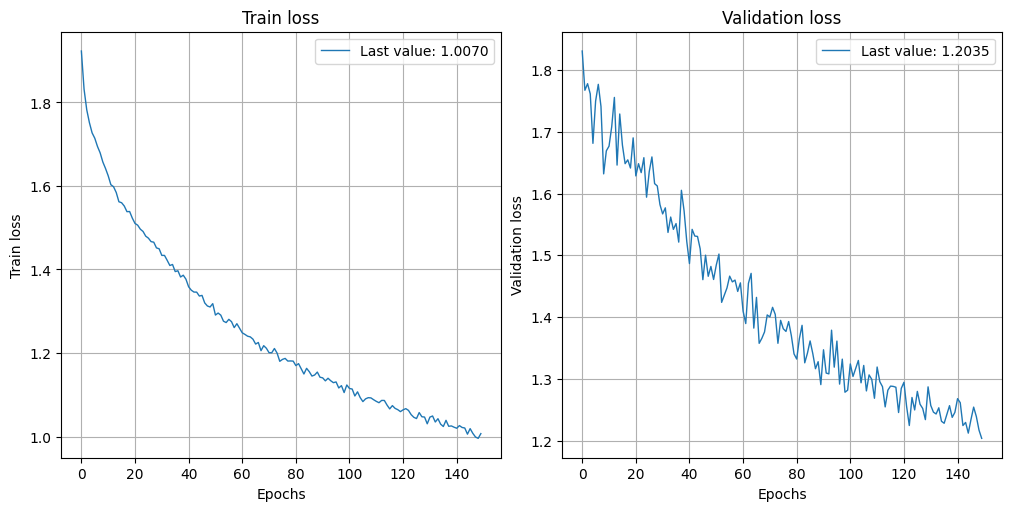

In [64]:
# Convert tensors to Python lists
history['train_loss'] = [x.cpu().numpy() if isinstance(x, torch.Tensor) else x for x in history['train_loss']]
history['validation_loss'] = [x.cpu().numpy() if isinstance(x, torch.Tensor) else x for x in history['validation_loss']]
history['train_acc'] = [x.cpu().numpy() if isinstance(x, torch.Tensor) else x for x in history['train_acc']]
history['validation_acc'] = [x.cpu().numpy() if isinstance(x, torch.Tensor) else x for x in history['validation_acc']]

# Show history
show_history(history)
plot_history(history, path="../history/emotion_classifier_training.png")
plt.close()

---